In [1]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import spacy

from gensim import models, corpora
from gensim import similarities
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud


In [2]:
data = pd.read_csv("../data/responses.csv")
data


,text,label
0,I'm having insomnia.,insomnia
1,I can't seem to fall asleep.,insomnia
2,I'm struggling to get some shut-eye.,insomnia
3,I'm tossing and turning at night.,insomnia
4,Sleep eludes me.,insomnia
...,...,...
235,I feel like I'm in a constant state of agitation.,anxiety
236,I have trouble with commitment due to anxiety.,anxiety
237,I feel like I'm always searching for safety.,anxiety
238,I feel like I'm constantly being reminded of m...,anxiety


In [3]:
nlp = spacy.load("en_core_web_sm", disable=["ner" "parse"])

def basic_filter(text):
    return [t.lemma_ for t in nlp(text) if
            not t.is_punct
            and not t.is_space
            and (t.lemma_ in {"not"} or not t.is_stop)]


In [4]:
data["tokenized_text"] = list(map(basic_filter, data["text"]))
data


,text,label,tokenized_text
0,I'm having insomnia.,insomnia,"[have, insomnia]"
1,I can't seem to fall asleep.,insomnia,"[not, fall, asleep]"
2,I'm struggling to get some shut-eye.,insomnia,"[struggle, shut, eye]"
3,I'm tossing and turning at night.,insomnia,"[toss, turn, night]"
4,Sleep eludes me.,insomnia,"[sleep, elude]"
...,...,...,...
235,I feel like I'm in a constant state of agitation.,anxiety,"[feel, like, constant, state, agitation]"
236,I have trouble with commitment due to anxiety.,anxiety,"[trouble, commitment, anxiety]"
237,I feel like I'm always searching for safety.,anxiety,"[feel, like, search, safety]"
238,I feel like I'm constantly being reminded of m...,anxiety,"[feel, like, constantly, remind, anxiety]"


In [5]:
# Build a Dictionary of word<-->id mappings.
NUM_TOPICS = 4

dictionary = corpora.Dictionary(data["tokenized_text"])
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus_bow = [dictionary.doc2bow(article)
              for article in data["tokenized_text"]]

sample_token = "sleep"
print(f"ID for \"{sample_token}\" token: {dictionary.token2id[sample_token]}")

ID for "sleep" token: 5


In [6]:
lda_model = models.LdaModel(corpus=corpus_bow, num_topics=NUM_TOPICS,
                            id2word=dictionary, passes=50, alpha="auto", eta="auto", random_state=1)
lda_model.print_topics()


[(0,
  '0.379*"sleep" + 0.249*"trouble" + 0.164*"anxiety" + 0.110*"have" + 0.071*"night" + 0.002*"control" + 0.002*"not" + 0.002*"thought" + 0.002*"life" + 0.002*"constantly"'),
 (1,
  '0.242*"not" + 0.232*"lose" + 0.149*"constantly" + 0.094*"feeling" + 0.076*"ability" + 0.067*"fall" + 0.066*"control" + 0.048*"life" + 0.003*"sleep" + 0.002*"anxiety"'),
 (2,
  '0.478*"state" + 0.326*"constant" + 0.118*"thought" + 0.007*"control" + 0.005*"constantly" + 0.005*"anxiety" + 0.005*"trouble" + 0.005*"anxious" + 0.005*"not" + 0.005*"sleep"'),
 (3,
  '0.347*"struggle" + 0.263*"go" + 0.221*"anxious" + 0.011*"fall" + 0.011*"control" + 0.011*"thought" + 0.011*"trouble" + 0.011*"sleep" + 0.011*"lose" + 0.011*"not"')]

In [7]:
results = []

for entry in range(len(data["tokenized_text"])):
    topics = sorted(lda_model.get_document_topics(
        corpus_bow[entry]), key=lambda tup: tup[1])[::-1]
    label = topics[0][0]
    results.append(label)

np.unique(results, return_counts=True)

(array([0, 1, 2, 3]), array([ 63, 144,  21,  12], dtype=int64))

In [8]:
def get_top_topics(article_idx, min_topic_prob):

    # Sort from highest to lowest topic probability.
    topic_prob_pairs = sorted(lda_model.get_document_topics(corpus_bow[article_idx],
                                                            minimum_probability=min_topic_prob),
                              key=lambda tup: tup[1])[::-1]

    word_prob_pairs = [lda_model.show_topic(
        pair[0]) for pair in topic_prob_pairs]
    topic_words = [[pair[0] for pair in collection]
                   for collection in word_prob_pairs]

    data = {
        "Major Topics": topic_prob_pairs,
        "Topic Words": topic_words
    }

    return pd.DataFrame(data)


In [9]:
coherence_model_lda = CoherenceModel(
    model=lda_model, texts=data["tokenized_text"], dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print("\nCoherence Score: ", coherence_lda)



Coherence Score:  -18.703854723519168


In [10]:
def render_word_cloud(model, rows, cols, max_words):
    word_cloud = WordCloud(background_color="white",
                           max_words=max_words, prefer_horizontal=1.0)
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(model.show_topic(i))
        word_cloud.generate_from_frequencies(topic_words)
        plt.gca().imshow(word_cloud, interpolation="bilinear")
        plt.gca().set_title("Topic {id}".format(id=i))
        plt.gca().axis("off")

    plt.axis("off")
    plt.show()


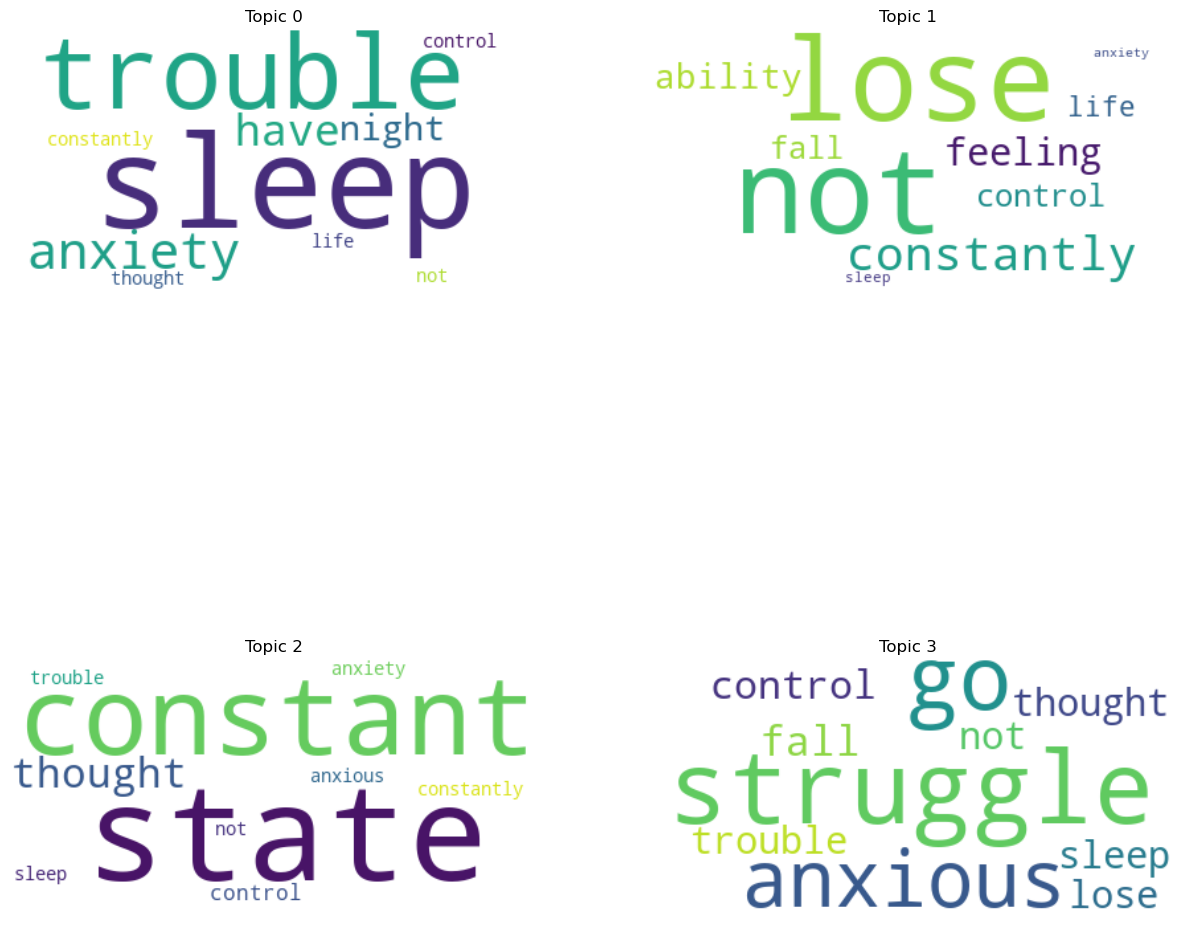

In [12]:
# Here we"ll visualize the first nine topics.
render_word_cloud(lda_model, 2, 2, 10)